In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
import torch.nn.functional as F

In [3]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def stats(x): return x.mean(),x.std()


In [4]:
#MNIST datasetup
mpl.rcParams['image.cmap'] = 'gray'
x_train,y_train,x_valid,y_valid = get_data()

n,m = x_train.shape
c = y_train.max()+1
number_hid = 50

In [5]:
class Model(nn.Module): #simple 3 layer Model
    def __init__(self, num_inputs, num_hidden, num_outputs):
            super().__init__() #initalize nn.Module
            self.layers = [nn.Linear(num_inputs, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_outputs)
                          ]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [6]:
model = Model(m, number_hid, 10)
pred = model(x_train)


$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 


$$\hbox{Cross Entropy Loss}$$ $$-\sum x\, \log p(x)$$

In [7]:
def log_softmax_standard(x): 
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

def log_softmax_simplified(x):
    return x - x.exp().sum(-1, keepdim=True).log()

#pytorch one-hot encoded Negative-Log Likelyhood
#indexs by actuals, using numpy integer array indexing over the number of rows
def one_hot_encoded_nll(input, target):
    return -input[range(target.shape[0]), target].mean()
    

In [8]:
sm_pred = log_softmax_simplified(pred)

loss = one_hot_encoded_nll(sm_pred, y_train)

In [9]:
print("Loss of model: %f"%(loss))

Loss of model: 2.299490


$$\hbox{Implementing the LogSumExp Trick}$$
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

In [10]:
#this allows us to find our largest input, subtract it from the other inputs, and then add it back  in
#this gives us the same result without worrying about e^(x) overflowing
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

#using softmax with nll
loss = one_hot_encoded_nll(log_softmax(pred), y_train)
pytorch_loss = F.nll_loss(F.log_softmax(pred, -1), y_train)
print("Loss: %f\nPytorch Loss: %f"%(loss,pytorch_loss))

Loss: 2.299490
Pytorch Loss: 2.299495


In [11]:
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

loss_function = F.cross_entropy
batch_size = 64
learning_rate = 0.5
num_epochs = 1



x_mini_batch = x_train[0:batch_size]
preds = model(x_mini_batch)
preds[0], preds.shape #64 batchsize * 10 categories

y_mini_batch = y_train[0:batch_size]
loss_function(preds, y_mini_batch)
accuracy(preds, y_mini_batch) #terrible, which is expected for an untrained model randomly guessing

tensor(0.0938)

----
a basic training loop

In [12]:
for epoch in range(num_epochs):
    for i in range((n-1)//batch_size +1):
        start_index = i *batch_size
        xmb = x_train[start_index: start_index + batch_size]
        ymb = y_train[start_index: start_index + batch_size]
        predictions = model(x_mini_batch)
        loss = loss_function(predictions, y_mini_batch)
        loss.backward() #calculate the gradients
        with torch.no_grad():
            for l in model.layers: #only updating layers with parameters, ie: not ReLUs
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * learning_rate
                    l.bias -= l.bias.grad * learning_rate
                    #zero the matricies' gradients
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
loss_function(model(x_mini_batch), y_mini_batch), accuracy(model(x_mini_batch), y_mini_batch)

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

---
Implementing Pytorch model.Parameters

adding capability to store list of attributes in our modules
```
class Module():
    def __init__(self, num_inputs, num_hidden, num_outputs):
        self._modules = {} #empty set to store our modules in
        self.layer1 = nn.Linear(num_inputs, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_outputs) #store layers in a list, this is inflexible
        
    def __setattr__(self, k,v):
        if not k.startswith("_"):
            self._modules[k] = v
            super().__setattr__(k,v) #using python object's __setattr__

    def __repr__(self):
        return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p
```

In [13]:
#plain example
class DumberModel(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.layer1 = nn.Linear(num_inputs, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_outputs)
    def __call__(self, x):
        return self.layer2(F.relu(self.layer1(x)))

class DumbModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): #add each layer as a Pytorch Module
            self.add_module(f'layer_{i}', l) #name_index and the layer itself
    def __call__(self, x):
        return self.layer2(F.relu(self.layer1(x)))

    
#sequential model example
class SequentialModel(nn.Module): #implementation of nn.Sequential
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [14]:
def fit():
    for epoch in range(num_epochs):
        for i in range((n-1)//batch_size +1):
            start_index = i * batch_size
            x_mb = x_train[start_index:start_index + batch_size]
            y_mb = y_train[start_index:start_index + batch_size]
            predictions = model(x_mb)
            loss = loss_function(predictions, y_mb)
            
            loss.backward()
            with torch.no_grad():
                for parameter in model.parameters():
                    parameter -= parameter.grad * learning_rate
                model.zero_grad()

---
# Using the Sequential Layer Model

In [15]:
num_categories = 10
layers = [nn.Linear(m, number_hid), nn.ReLU(), nn.Linear(number_hid, num_categories)]
model = SequentialModel(layers)
print(model)

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [16]:
loss_function = F.cross_entropy
batch_size = 64
learning_rate = 0.5
num_epochs = 1
fit()
loss_function(model(x_mini_batch), y_mini_batch), accuracy(model(x_mini_batch), y_mini_batch)

(tensor(0.2104, grad_fn=<NllLossBackward>), tensor(0.9375))

# Using Pytorch's nn.Sequential

In [17]:
model = nn.Sequential(nn.Linear(m, number_hid), nn.ReLU(), nn.Linear(number_hid, num_categories))
fit()
loss_function(model(x_mini_batch), y_mini_batch), accuracy(model(x_mini_batch), y_mini_batch)

(tensor(0.1953, grad_fn=<NllLossBackward>), tensor(0.9375))

---
# Implementing torch.optim

In [18]:
class Optimizer():
    def __init__(self, parameters_in, learning_rate_in = 0.5):
        self.parameters = list(parameters_in)
        self.lr = learning_rate_in
        
    def step(self): #executes one step of backward pass
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr
    
    def zero_gradients(self):
        #prevents optimization of all of model's parameters
        for p in self.parameters: #optimize the parameters passed to the parameters
            p.grad.data.zero_()
        

In [19]:
model = nn.Sequential(nn.Linear(m, number_hid), nn.ReLU(), nn.Linear(number_hid, num_categories))
opt = Optimizer(model.parameters())

In [20]:
#adding optimizer to the training loop
def fit():
    for i in range(epochs):
        for i in range ((n-1)//batch_size +1):
            start_i = i*batch_size
            end_i = start_i+batch_size
            x_mini_batch = x_train[start_i:end_i]
            y_mini_batch = y_train[start_i:end_i]
            predictions = model(x_mini_batch)
            loss = loss_function(predictions, y_mini_batch)
            
            loss.backward()
            opt.step()
            opt.zero_gradients()

In [21]:
loss,acc = loss_function(model(x_mini_batch), y_mini_batch), accuracy(model(x_mini_batch), y_mini_batch)
loss,acc

(tensor(2.3037, grad_fn=<NllLossBackward>), tensor(0.0781))

## Optim.SGD

In [22]:
optim.SGD.step??

Signature: optim.SGD.step(self, closure=None)
Source:   
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['mome

### Using Optim.SGD

In [23]:
def get_model():
    model = nn.Sequential(nn.Linear(m, number_hid), nn.ReLU(), nn.Linear(number_hid, num_categories))
    return model, optim.SGD(model.parameters(), lr = learning_rate)

In [24]:
model, optimizer = get_model()
loss_function(model(x_mini_batch), y_mini_batch)

tensor(2.3175, grad_fn=<NllLossBackward>)

---
# Handling Data with Torch.utils.data.Dataset and Dataloader

In [25]:
class Dataset():
    def __init__(self, x_ds, y_ds):
        self.x_dataset = x_ds
        self.y_dataset = y_ds
    
    def __len__(self):
        return len(self.x_dataset)
    
    def __getitem__(self, i):
        return self.x_dataset[i],self.y_dataset[i]

In [26]:
#testing it out
train_dataset, valid_dataset = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_dataset) == len(x_train) and len(valid_dataset) == len(x_valid)
x_mb,y_mb = train_dataset[:5]
assert x_mb.shape == (5,28*28) and y_mb.shape == (5, )
x_mb, y_mb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [27]:
model, optimizer = get_model()
# def fit():
for epoch in range(num_epochs):
    for i in range((n-1)//batch_size + 1):
        xb,yb = train_dataset[i*batch_size : i*batch_size+batch_size]
        pred = model(xb)
        loss = loss_function(pred, yb)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
# fit()

In [28]:
loss,acc = loss_function(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0957, grad_fn=<NllLossBackward>), tensor(0.9375))

In [29]:
class DataLoader():#making calls to datasets more fluent
    def __init__(self, dataset, batchsize):
        self.dataset = dataset
        self.batch_size = batch_size
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            yield self.dataset[i:i+self.batch_size]

In [30]:
train_dl = DataLoader(train_dataset, batch_size)
valid_dl = DataLoader(valid_dataset, batch_size)

tensor(3)

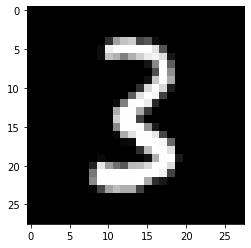

In [31]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(batch_size,28*28)
assert yb.shape==(batch_size,)
plt.imshow(xb[0].view(28,28))
yb[0]

In [32]:
#the freshest model, optimizer, and training loop
model, opt = get_model()
def fit():
    for epoch in range(num_epochs): #go through each epoch
        for x_mb,y_mb in train_dl: #go through each batch, in size of mini_batch
            predictions = model(x_mb) #calculate predictions on minibatch
            loss = loss_function(predictions, y_mb) #calculate the loss
            loss.backward() #calculate the gradients
            opt.step() #apply the gradients to our weights, w/learning rate
            opt.zero_grad() #zero out our weight's gradients
            
fit()
loss, accuracy = loss_function(model(x_mb), y_mb), accuracy(model(x_mb), y_mb)
loss, accuracy

(tensor(0.0472, grad_fn=<NllLossBackward>), tensor(1.))

In [33]:
#refactoring Dataloader to include randomness
class Sampler():
    def __init__(self, dataset, batchsize, shuffle = False):
        self.length = len(dataset)
        self.batch_size = batchsize
        self.shuffle= shuffle
    
    def __iter__(self):
        self.indexs = torch.randperm(self.length) if self.shuffle else torch.arrange(self.length)
        for i in range(0, self.length, self.batch_size):
            yield self.indexs[i:i+self.batch_size]
            
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys) #combines tensors on a new axis
            
class Dataloader():
    def __init__(self, dataset, sampler, collate_fn = collate):
        self.dataset = dataset
        self.sampler = sample
        self.collate_function = collate_fn
        
    def __iter__(self):
        for sample in self.sampler:
            yield self.collate_function([self.ds[i] for i in sample])

(tensor(5), tensor(3))

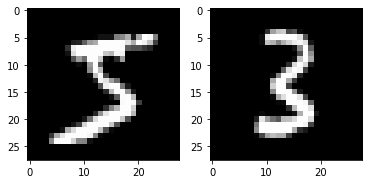

In [34]:
#setup the samplers
train_samp = Sampler(train_dataset, batch_size, shuffle=True)
valid_samp = Sampler(valid_dataset, batch_size, shuffle=False)
#setup the Dataloaders
train_dl = DataLoader(train_dataset, train_samp)
valid_dl = DataLoader(valid_dataset, train_samp)

#show off some data
fig, ax = plt.subplots(1,2)
x_mb,y_mb = next(iter(valid_dl))
x_mb1,y_mb1 = next(iter(train_dl))
ax[0].imshow(x_mb1[0].view(28,28));
ax[1].imshow(x_mb[0].view(28,28));
y_mb1[0], y_mb[0]

In [35]:
model,opt = get_model()
fit()

loss = loss_function(model(x_mb), y_mb)
loss

tensor(0.1416, grad_fn=<NllLossBackward>)

---
# Pytorch Dataloader and Sampler

In [36]:
batch_size = 64
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean() #redefined here, somehow tensor object was trying to be called
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=RandomSampler(train_dataset), collate_fn=collate)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size, sampler=SequentialSampler(valid_dataset), collate_fn=collate)

model,opt = get_model()
fit()
print(loss_function(model(xb), yb), accuracy(model(xb), yb))

#using Pytorch Defaults
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)

model,opt = get_model()
fit()
print(loss_function(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1305, grad_fn=<NllLossBackward>) tensor(0.9688)
tensor(0.1126, grad_fn=<NllLossBackward>) tensor(0.9531)


---
# Validating our  Model

### Example of layers that rely on the Training flag
- nn.BatchNorm2d - 2-dimensional Batch Normalization
- nn.Dropout - DropOut Module Optimization 

In [37]:
#redefining fit to use Pytorch's Internal Attributes
def fit(epoch, model, loss_func, opt, train_dl, valid_dl):
    for e in range(epoch):
        model.train() #turn training flag to True
        for x_mb, y_mb in train_dl:
            predictions = model(x_mb)
            loss = loss_func(predictions, y_mb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval() #turn training flag to False
        with torch.no_grad():
            total_loss, total_accuracy = 0.,0. #only works with equal batchsizes, need to implement weighted combinations
            for x_mb, y_mb in valid_dl:
                predictions = model(x_mb)
                total_loss += loss_func(predictions, y_mb)
                total_accuracy += accuracy(predictions, y_mb)
        nv = len(valid_dl)
        print(e, total_loss/nv, total_accuracy/nv)
    return total_loss/nv, total_accuracy/nv
    

In [38]:
#a simple function to get the dataloaders needed for training, note validation does not need to store the gradients so we can grab more
def get_dataloaders(train_ds, valid_ds, bs, **kwargs):
    return (torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            torch.utils.data.DataLoader(valid_ds, batch_size=bs*2, **kwargs))

---
training in 3 lines

In [39]:
train_dl,valid_dl = get_dataloaders(train_dataset, valid_dataset, 64)
model,opt = get_model()
loss,acc = fit(5, model, loss_function, opt, train_dl, valid_dl)

0 tensor(0.3211) tensor(0.8911)
1 tensor(0.1336) tensor(0.9595)
2 tensor(0.1124) tensor(0.9665)
3 tensor(0.1235) tensor(0.9638)
4 tensor(0.1012) tensor(0.9725)
